In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import os

os.environ['USE_PYGEOS']='0'

# Display all columns in the df
pd.set_option('display.max_columns', None)
# Set the float format to display numbers in standard decimal notation
pd.options.display.float_format = '{:.5f}'.format

#Read csv
df=pd.read_csv(r"/Users/antonglad/Desktop/Python_Recreation/graph_w_CS_and_volume_wCorrectLength.csv")

## Creation of main processing function

In [2]:

#Define function which calculates main dataframe values
def process_df(ev_ratio, df): 
    df=df.copy()
    #Adding range of vehicles, lot of analysis to be done here (can also create custom ranges for for different regions...)
    df["range"]=300

    #Creating dictionairy showcasing the loss of range per season 
    temp_cost={'january':0.8, 
            'february':0.8, 
            'march':0.8, 
            'april':0.9, 
            'may':1, 
            'june':1.05, 
            'july':1.1, 
            'august':1.1, 
            'september':1.02, 
            'october':0.92, 
            'november':0.82, 
            'december':0.8} 

    #Part of Method 1
    for key in temp_cost.keys():
        df.loc[:, f'actual_range_{key[:3].lower()}'] = df['range'] * temp_cost[key]



    # Define a dictionary to map the old column names to the new column names
    col_map = {i: f"vol_{month[:3].lower().strip()}" for i, month in zip(range(1, 13), temp_cost.keys())}

    # Manually change the column names
    new_names = {'1': 'vol_jan', '2': 'vol_feb', '3': 'vol_mar', '4': 'vol_apr', '5': 'vol_may', '6': 'vol_jun', '7': 'vol_jul', '8': 'vol_aug', '9': 'vol_sep', '10': 'vol_oct', '11': 'vol_nov', '12': 'vol_dec'}

    # Rename the columns using the dictionary
    df = df.rename(columns=new_names)

    # Loop through each row of the dataframe
    for index, row in df.iterrows():
        # Calculate the mean of the non-missing values in the row
        row_mean = int(row[['vol_jan', 'vol_feb', 'vol_mar', 'vol_apr', 'vol_may', 'vol_jun', 'vol_jul', 'vol_aug', 'vol_sep', 'vol_oct', 'vol_nov', 'vol_dec']].mean(skipna=True))

        # Fill the missing values in the row with the row mean
        df.loc[index] = row.fillna(row_mean)


    # Find charging probability distribution
    #Formula: p = edge_length / battery_range (actual)

    #Method 1: Decreases the range by a factor of temperature
    # # Loop through each month in the temp_cost dictionary
    for month in temp_cost.keys():
        # Create a new column name for the charging probability
        col_name = f"charge_prob_{month[:3].lower()}"
        # Calculate the charging probability using the corresponding actual range column, (multiplied by 1000 because range is in km, while length is in meters)
        df[col_name] = df['length'] / (df[f'actual_range_{month[:3].lower()}'] * 1000)


    ################################################################
    
    public_charging=0.3

    # Loop through each month in the temp_cost dictionary
    for month in temp_cost.keys():
        # Create a new column name for the charging probability
        col_name = f"charge_cars_{month[:3].lower()}"
        # Calculate the charging probability using the corresponding actual length column and a fixed range of 300 (remove public charging variable)
        df[col_name] = ((df[f'vol_{month[:3].lower()}'] * (df[f'charge_prob_{month[:3].lower()}'])) * ev_ratio) #*public_charging
        df[col_name] = df[col_name].astype(int)



    # Define a list of the column names to convert to integer type
    cols_to_convert = ['vol_jan', 'vol_feb', 'vol_mar', 'vol_apr', 'vol_may', 'vol_jun', 
                    'vol_jul', 'vol_aug', 'vol_sep', 'vol_oct', 'vol_nov', 'vol_dec', 
                    'range', 'actual_range_jan', 'actual_range_feb', 'actual_range_mar', 
                    'actual_range_apr', 'actual_range_may', 'actual_range_jun', 
                    'actual_range_jul', 'actual_range_aug', 'actual_range_sep', 
                    'actual_range_oct', 'actual_range_nov', 'actual_range_dec']

    # Convert the columns to integer type
    df[cols_to_convert] = df[cols_to_convert].astype(int)

    return df


## Finding hourly traffic patterns

<ipython-input-3-e2117ed9524e>:50: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r-" (-> color='r'). The keyword argument will take precedence.
  ax.plot(x_smooth, y_smooth, 'r-', color="darkred", lw=2)


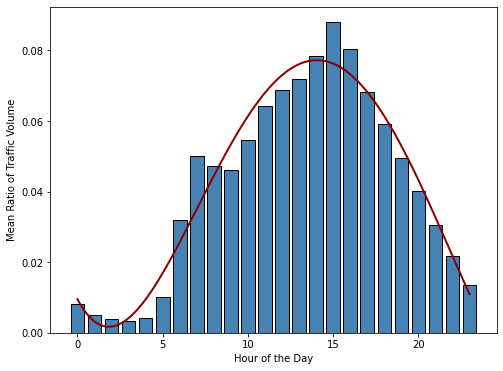

In [3]:
import pandas as pd

#Investigating real traffic hourly patterns of the day based on real data (not pivoted spreadsheet)
hourly=pd.read_csv(r"/Users/antonglad/Desktop/Python_Recreation/completeAllHourlyVolume_EasterAprJulSep.csv")

# Group the DataFrame by hour and sum the traffic volume
total_traffic_by_hour = hourly.groupby(['from_hour'])['volume'].sum()

# Calculate the total traffic volume for the entire day
total_traffic = hourly['volume'].sum()

# Calculate the mean ratio for each hour of the day
mean_ratios = total_traffic_by_hour / total_traffic


from scipy.interpolate import make_interp_spline, UnivariateSpline
import numpy as np
import matplotlib.pyplot as plt

# Convert the mean ratios to a list
mean_ratios_list = mean_ratios.tolist()

# Create a list of the hour values
hours = mean_ratios.index.tolist()

# # Extract just the hour from the from_hour column
# hours = [x.split(':')[0] for x in hours]

# Extract just the hour from the from_hour column
hours = [int(x.split(':')[0]) for x in hours]  # Convert to integers

# Create the figure and axes
fig, ax = plt.subplots(figsize=(8, 6))

# Create the histogram
ax.bar(hours, mean_ratios_list, edgecolor='black', color="steelblue")

# Set the x-axis label
ax.set_xlabel('Hour of the Day')

# Set the y-axis label
ax.set_ylabel('Mean Ratio of Traffic Volume')

# Generate the spline
x_smooth = np.linspace(min(hours), max(hours), 200)
#spl = make_interp_spline(hours, mean_ratios_list, k=3)  #Smoothing method 1 : more precise (less nice)
spl = UnivariateSpline(hours, mean_ratios_list, k=4, s=1)  # Smoothing method 2 : less precise, more smooth (more nice)
y_smooth = spl(x_smooth)
# Add the spline to the plot
ax.plot(x_smooth, y_smooth, 'r-', color="darkred", lw=2)

# Show the plot
plt.show()

## Creation of Charging JSON - used to calculate supply

In [4]:
import pandas as pd
import json
from json import JSONEncoder
import ast


class CustomJSONEncoder(JSONEncoder):
    def default(self, obj):
        if isinstance(obj, pd.core.series.Series):
            return obj.tolist()
        return super(CustomJSONEncoder, self).default(obj)

# Assuming your dataframe is called 'df'
charging_cols = ['u', 'v', 'CS_id', 'PowerKW_list', 'Number_Of_Chargers', 'Name']

# Create a new DataFrame with the selected columns
cs_data = df[charging_cols].copy()

# Create a new DataFrame with rows where 'PowerKW_list' is 'No CS' (This will be used for experiments)
no_cs_df = cs_data.loc[cs_data['PowerKW_list'] == 'No CS'].copy()
#Export the roads with no charging stations to CSV
no_cs_df.to_csv("roads_without_CS.csv")

# Initialize an empty dictionary to store the data
data_dict = {}

# Iterate through the dataframe rows
for index, row in cs_data.iterrows():
    # Create a key for the unique combination of 'u' and 'v'
    key = f"{row['u']}_{row['v']}"

    # If the key is not in the dictionary, create a new entry
    if key not in data_dict:
        data_dict[key] = {'CS_ids': [], 'PowerKW_lists': []}

    # Append the CS_id and PowerKW_list for the current row to the corresponding lists
    data_dict[key]['CS_ids'].append(row['CS_id'])
    if row['PowerKW_list'] == "No CS":
        data_dict[key]['PowerKW_lists'].append("No CS")
    else:
        data_dict[key]['PowerKW_lists'].append([float(x) for x in ast.literal_eval(row['PowerKW_list'])])
# Convert the dictionary to a JSON object
json_data = json.dumps(data_dict, indent=2, cls=CustomJSONEncoder)


# assume `json_str` contains your JSON formatted string
with open('edge_cs_data.json', 'w') as f:
    f.write(json_data)


# Load the JSON data
with open('edge_cs_data.json') as f:
    data = json.load(f)

# Iterate through each element of the PowerKW_lists arrays
for key, value in data.items():
    for i, lst in enumerate(value['PowerKW_lists']):
        # Use a list comprehension to filter out the values that are equal to 22
        filtered_lst = [x for x in lst if x not in [22.0, 25.0]]
        # Replace the original list with the filtered list
        value['PowerKW_lists'][i] = filtered_lst

# Save the updated JSON data
with open('updated_json_file.json', 'w') as f:
    json.dump(data, f, indent=2)


## Creation of supply and demand variables function

In [7]:
def process_json(df, mean_ratios):

    #Dictionary containing the amount of cars that can charge per hour at chargers with different capacities (data from Excel spreadsheet)
    #Set-Up time accounted for (10%)
    cars_per_hour_dict={
        350: 4.6,
        300: 4.0,
        250: 3.3,
        200: 2.6,
        180: 2.4,
        175: 2.3,
        150: 2.0,
        135: 1.8,
        129: 1.7,
        125: 1.7,
        120: 1.6,
        100: 1.3,
        75: 1.0,
        62.5: 0.8,
        62: 0.8,
        60: 0.8,
        55: 0.7,
        50: 0.7,
        48: 0.6,
        44: 0.6,
        43: 0.6
    }

    # Load the updated JSON data
    with open('updated_json_file.json') as f:
        python_data = json.load(f)

    # Create an empty list to hold the calculated values
    calc_values = []

    # Loop over each ID in the Python object
    for id_, values in python_data.items():
        # Skip the iteration if either "CS_ids" or "PowerKW_lists" keys have invalid values
        if not values['CS_ids'] or not all(isinstance(power, (float, int)) for power_list in values['PowerKW_lists'] for power in power_list):
            continue
        # Calculate the total capacity for the ID by summing the capacities in the "PowerKW_lists" key
        total_capacity = sum([sum([cars_per_hour_dict[power] for power in power_list]) for power_list in values['PowerKW_lists']])
        
        # Append the ID and calculated value to the list
        calc_values.append((id_, total_capacity))

    # Create a DataFrame from the list of calculated values
    edge_supply = pd.DataFrame(calc_values, columns=['ID', 'CalcValue'])


    edge_supply = edge_supply.rename(columns={'ID': 'new_id'})

    df["new_id"] = df["u"].astype(str) + "_" + df["v"].astype(str)

    # Assuming the other dataframe is called "other_df"
    merged_df = df.merge(edge_supply, on='new_id')

    merged_df = merged_df.rename(columns={'CalcValue': 'Charge_Supply'})

    unique_counts = merged_df['Charge_Supply'].value_counts()
    unique_values = unique_counts.index.tolist()
    occurrences = unique_counts.tolist()

    #for i in range(len(unique_values)):
        #print("Value: {}, Occurrences: {}".format(unique_values[i], occurrences[i]))


    #New dataframe creation which excludes duplicates rows (results in as many rows as edges)
    every_edge= merged_df.drop_duplicates(subset='new_id', keep='first')


    # Helper function to distribute the cars per edge using the mean_ratios
    def distribute_cars(cars, mean_ratios):
        return [cars * ratio for ratio in mean_ratios]

    # Extract hour ratios from mean_ratios
    hour_ratios = mean_ratios.values.tolist()


    # Prepare a list of month abbreviations
    months = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']

    # Initialize an empty dictionary to store the DataFrames for each month
    monthly_dfs = {}

    # Iterate over each month
    for month in months:
        # Create a new DataFrame with the same index as new_df
        monthly_df = every_edge[['u', 'v']].copy()
        
        # Distribute cars for each edge and each hour of the day
        for hour, ratio in enumerate(hour_ratios):
            hourly_column_name = f'hour_{hour:02d}_{month}'
            monthly_df[hourly_column_name] = every_edge[f'charge_cars_{month}'].mul(ratio)


        
        # Store the resulting DataFrame in the dictionary
        monthly_dfs[month] = monthly_df


    # Initialize an empty dictionary to store the DataFrames for each month
    supply_demand_difference = {}

    # Iterate over each month
    for month in months:
        # Get the corresponding DataFrame for the month
        monthly_df = monthly_dfs[month].copy()
        
        # Iterate over each hour of the day
        for hour in range(24):
            hourly_column_name = f'hour_{hour:02d}_{month}'
            
            # Calculate the supply-demand difference for each hour
            supply_demand_difference_hour = every_edge['Charge_Supply'] - monthly_df[hourly_column_name]
            
            # Replace the hourly column with the supply-demand difference
            diff_hourly_column_name = f'diff_hour_{hour:02d}_{month}'
            monthly_df[diff_hourly_column_name] = supply_demand_difference_hour

            # Drop the original hourly column
            monthly_df = monthly_df.drop(hourly_column_name, axis=1)
        
        # Add edge classification to the monthly DataFrame
        # Create a DataFrame to store the classification
        classification_df = pd.DataFrame(index=monthly_df.index, columns=["edge_classification"])


        # Iterate over the edges
        for edge in monthly_df.index:
            # Get the supply-demand difference values for the edge
            diff_values = monthly_df.loc[edge][2:]
            
            # Check if all values are positive
            if (diff_values > 0).all():
                classification = 1
            # Check if all values are negative
            elif (diff_values < 0).all():
                classification = -1
            # Otherwise, the values are mixed
            else:
                classification = 0
            
            # Store the classification for the edge
            classification_df.loc[edge, "edge_classification"] = classification

        # Merge the classification DataFrame with the monthly DataFrame
        monthly_df = pd.concat([monthly_df, classification_df], axis=1)

        # Store the resulting DataFrame in the dictionary
        supply_demand_difference[month] = monthly_df

    return supply_demand_difference


## Testing classification output

In [9]:
# Initialize a DataFrame to store the counts
classification_counts = pd.DataFrame(columns=["-1", "0", "1"])

# Prepare a list of month abbreviations
months = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']

# Iterate over each month
for month in months:
    # Get the corresponding DataFrame for the month
    monthly_df = supply_demand_difference[month].copy()

    # Count the occurrences of each classification
    counts = monthly_df["edge_classification"].value_counts()

    # Add the counts to the classification_counts DataFrame
    classification_counts.loc[month] = [counts.get(-1, 0), counts.get(0, 0), counts.get(1, 0)]

print(classification_counts)


NameError: name 'supply_demand_difference' is not defined

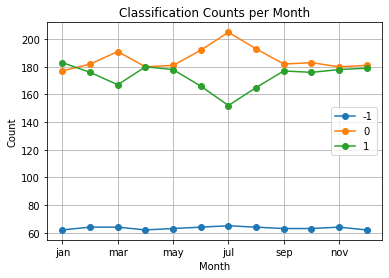

In [67]:
classification_counts.plot(kind='line', marker='o')
plt.title('Classification Counts per Month')
plt.xlabel('Month')
plt.ylabel('Count')
plt.grid(True)
plt.show()


## Computing supply and demand difference based on different EV-adoption rate scenarios

In [10]:
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)


# Specify the values of ev_ratio to use in the sensitivity analysis
ev_ratio_values = np.arange(0.2, 0.75, 0.01)

# Initialize a DataFrame to store the counts
classification_counts = pd.DataFrame()

# Iterate over the values of ev_ratio
for ev_ratio in tqdm(ev_ratio_values, desc='Processing ev_ratios'):
    # Process the DataFrame
    df = process_df(ev_ratio, df)
    
    # Process the JSON data
    supply_demand_difference = process_json(df, mean_ratios)

    # Prepare a list of month abbreviations
    months = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']

    # Initialize a DataFrame to store the counts for this value of ev_ratio
    ev_ratio_counts = pd.DataFrame(index=months, columns=["-1", "0", "1"])

    # Iterate over each month
    for month in tqdm(months, desc=f'Processing months for ev_ratio={ev_ratio}', leave=False):
        # Get the corresponding DataFrame for the month
        monthly_df = supply_demand_difference[month].copy()

        # Count the occurrences of each classification
        counts = monthly_df["edge_classification"].value_counts()

        # Add the counts to the ev_ratio_counts DataFrame
        ev_ratio_counts.loc[month] = [counts.get(-1, 0), counts.get(0, 0), counts.get(1, 0)]

    # Add ev_ratio column to ev_ratio_counts
    ev_ratio_counts['ev_ratio'] = ev_ratio

    # Append the ev_ratio_counts DataFrame to the classification_counts DataFrame
    classification_counts = pd.concat([classification_counts, ev_ratio_counts.reset_index().rename(columns={'index': 'month'})])

# Calculate the mean counts for each ev_ratio
classification_counts_mean = classification_counts.groupby('ev_ratio').mean()

print(classification_counts_mean)


Processing ev_ratios: 100%|██████████| 55/55 [12:14<00:00, 13.35s/it]

               -1         0         1
ev_ratio                             
0.20000  61.33333 101.50000 259.16667
0.21000  61.41667 105.50000 255.08333
0.22000  61.75000 110.08333 250.16667
0.23000  61.83333 113.25000 246.91667
0.24000  61.83333 115.91667 244.25000
0.25000  62.00000 119.58333 240.41667
0.26000  62.00000 123.33333 236.66667
0.27000  62.08333 127.41667 232.50000
0.28000  62.08333 131.16667 228.75000
0.29000  62.08333 134.91667 225.00000
0.30000  62.16667 139.50000 220.33333
0.31000  62.16667 142.08333 217.75000
0.32000  62.33333 146.50000 213.16667
0.33000  62.33333 150.75000 208.91667
0.34000  62.33333 154.58333 205.08333
0.35000  62.33333 157.66667 202.00000
0.36000  62.33333 159.91667 199.75000
0.37000  62.41667 162.00000 197.58333
0.38000  62.41667 164.25000 195.33333
0.39000  62.41667 166.33333 193.25000
0.40000  62.50000 168.66667 190.83333
0.41000  62.50000 170.41667 189.08333
0.42000  62.50000 171.91667 187.58333
0.43000  62.58333 173.83333 185.58333
0.44000  62.

## Plotting sensitivity analysis of adpotion rates on classification data

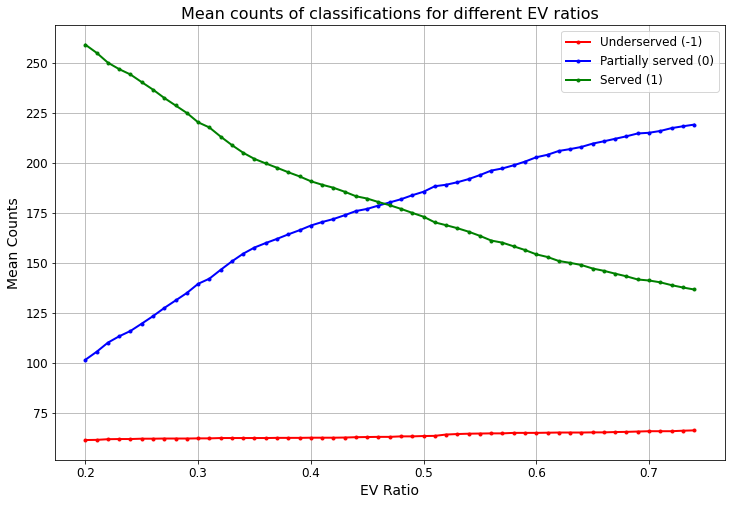

In [11]:
import matplotlib.pyplot as plt

# Create a new figure and axis
fig, ax = plt.subplots(figsize=(12, 8))

# Plot each classification on the same axis with specified color, line width and marker
ax.plot(classification_counts_mean.index, classification_counts_mean['-1'], label='Underserved (-1)', color='red', linewidth=2.0, marker='o', linestyle='-', markersize=3)
ax.plot(classification_counts_mean.index, classification_counts_mean['0'], label='Partially served (0)', color='blue', linewidth=2.0, marker='o', linestyle='-', markersize=3)
ax.plot(classification_counts_mean.index, classification_counts_mean['1'], label='Served (1)', color='green', linewidth=2.0, marker='o', linestyle='-', markersize=3)

# Add labels and title with increased font size
ax.set_xlabel('EV Ratio', fontsize=14)
ax.set_ylabel('Mean Counts', fontsize=14)
ax.set_title('Mean counts of classifications for different EV ratios', fontsize=16)

# Increase tick size
ax.tick_params(axis='both', which='major', labelsize=12)

# Add a grid
ax.grid(True)

# Add a legend with increased font size
ax.legend(fontsize=12)

# Show the plot
plt.show()


## Using proportions instead of counts on the Y-axis

In [12]:
# Calculate the total counts for each ev_ratio
classification_counts_mean['total'] = classification_counts_mean.sum(axis=1)

# Calculate the proportions for each classification
classification_counts_mean_proportions = classification_counts_mean.copy()
classification_counts_mean_proportions["-1"] = classification_counts_mean["-1"] / classification_counts_mean['total']
classification_counts_mean_proportions["0"] = classification_counts_mean["0"] / classification_counts_mean['total']
classification_counts_mean_proportions["1"] = classification_counts_mean["1"] / classification_counts_mean['total']

# Drop the 'total' column as it is not needed anymore
classification_counts_mean_proportions = classification_counts_mean_proportions.drop(columns=['total'])

print(classification_counts_mean_proportions)



              -1       0       1
ev_ratio                        
0.20000  0.14534 0.24052 0.61414
0.21000  0.14554 0.25000 0.60446
0.22000  0.14633 0.26086 0.59281
0.23000  0.14652 0.26836 0.58511
0.24000  0.14652 0.27468 0.57879
0.25000  0.14692 0.28337 0.56971
0.26000  0.14692 0.29226 0.56082
0.27000  0.14712 0.30194 0.55095
0.28000  0.14712 0.31082 0.54206
0.29000  0.14712 0.31971 0.53318
0.30000  0.14731 0.33057 0.52212
0.31000  0.14731 0.33669 0.51600
0.32000  0.14771 0.34716 0.50513
0.33000  0.14771 0.35723 0.49506
0.34000  0.14771 0.36631 0.48598
0.35000  0.14771 0.37362 0.47867
0.36000  0.14771 0.37895 0.47334
0.37000  0.14791 0.38389 0.46821
0.38000  0.14791 0.38922 0.46288
0.39000  0.14791 0.39415 0.45794
0.40000  0.14810 0.39968 0.45221
0.41000  0.14810 0.40383 0.44806
0.42000  0.14810 0.40739 0.44451
0.43000  0.14830 0.41193 0.43977
0.44000  0.14870 0.41686 0.43444
0.45000  0.14889 0.41943 0.43167
0.46000  0.14909 0.42338 0.42753
0.47000  0.14909 0.42713 0.42378
0.48000  0

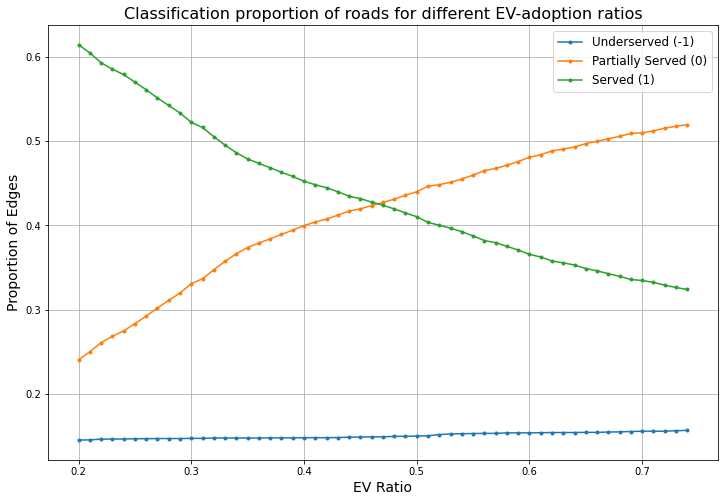

In [14]:
# Create a new figure and axis
fig, ax = plt.subplots(figsize=(12, 8))

# Plot each classification on the same axis with dot markers
ax.plot(classification_counts_mean_proportions.index, classification_counts_mean_proportions['-1'], marker='o', linestyle='-', markersize=3, label='Underserved (-1)')
ax.plot(classification_counts_mean_proportions.index, classification_counts_mean_proportions['0'], marker='o', linestyle='-', markersize=3, label='Partially Served (0)')
ax.plot(classification_counts_mean_proportions.index, classification_counts_mean_proportions['1'], marker='o', linestyle='-', markersize=3, label='Served (1)')

# Add labels and title
ax.set_xlabel('EV Ratio', fontsize=14)
ax.set_ylabel('Proportion of Edges', fontsize=14)
ax.set_title('Classification proportion of roads for different EV-adoption ratios', fontsize=16)
ax.grid(True)
# Add a legend
ax.legend(fontsize=12)

# Show the plot
plt.show()


### Using data from NTP (Tabell V.6 NB19-banene. Bestand av personbiler 2010 - 2050, etter energiteknologi)

### Data from: Electriying the Vehicle Fleet: Projections for Norway 2018-2050
### https://www.toi.no/getfile.php?mmfileid=50202

In [56]:
ad_rate=pd.read_excel("/Users/antonglad/Desktop/Python_Recreation/adoption_rate.xlsx")
ad_rate.head()

,Ar,Antall alt,Bensin,Diesel,Ikke- ladbar hybrid,Ladbar hybrid,Batteri,Hydrogen,Annet
0,2010,2294449,1492704,799521,85,0,2068,19,52
1,2011,2357995,1439086,914811,103,0,3898,35,62
2,2012,2422714,1399783,1014549,293,0,8012,20,57
3,2013,2474332,1358655,1095836,1999,0,17714,20,108
4,2014,2525872,1317731,1168448,968,0,38564,21,140


In [57]:
# Calculate ratios
ratios = ad_rate.iloc[:, 2:].div(ad_rate['Antall alt'], axis=0) * 100

# Create the ad_ratio DataFrame
ad_ratio = pd.DataFrame({
    'Year': ad_rate['Ar'],
    'Total': ad_rate['Antall alt'],
    'Bensin_ratio': ratios['Bensin'],
    'Diesel_ratio': ratios['Diesel'],
    'Ikke-ladbar_hybrid_ratio': ratios['Ikke- ladbar hybrid'],
    'Ladbar_hybrid_ratio': ratios['Ladbar hybrid'],
    'Batteri_ratio': ratios['Batteri'],
    'Hydrogen_ratio': ratios['Hydrogen'],
    'Annet_ratio': ratios['Annet']
})

ad_ratio.head()

,Year,Total,Bensin_ratio,Diesel_ratio,Ikke-ladbar_hybrid_ratio,Ladbar_hybrid_ratio,Batteri_ratio,Hydrogen_ratio,Annet_ratio
0,2010,2294449,65.05719,34.84588,0.00370,0.00000,0.09013,0.00083,0.00227
1,2011,2357995,61.03007,38.79614,0.00437,0.00000,0.16531,0.00148,0.00263
2,2012,2422714,57.77748,41.87655,0.01209,0.00000,0.33070,0.00083,0.00235
3,2013,2474332,54.90997,44.28816,0.08079,0.00000,0.71591,0.00081,0.00436
4,2014,2525872,52.16935,46.25919,0.03832,0.00000,1.52676,0.00083,0.00554


In [58]:
ad_ratio.tail()

,Year,Total,Bensin_ratio,Diesel_ratio,Ikke-ladbar_hybrid_ratio,Ladbar_hybrid_ratio,Batteri_ratio,Hydrogen_ratio,Annet_ratio
36,2046,3344599,1.06333,1.82895,0.06557,23.65010,73.38189,0.00966,0.00048
37,2047,3360156,0.95335,1.63284,0.05443,23.27115,74.07900,0.00881,0.00042
38,2048,3372137,0.85898,1.46026,0.04531,22.87535,74.75177,0.00798,0.00036
39,2049,3380975,0.77697,1.30752,0.03771,22.46864,75.40165,0.00722,0.00033
40,2050,3387526,0.70467,1.17177,0.03132,22.05468,76.03074,0.00652,0.00030


### From this we can see that by 2050, around 75% of the whole vehicle fleet will be battery powered, while 22% will be hybrids

## Next step: Altering vehicle range over time

In [26]:
#Many sources which will cnotribute to validity of estimates. We believe that the estimates used are quite conservative
#https://www.statista.com/statistics/970998/range-trends-electric-vehicles/
#Another factor that can be considered is major technological breakthroughs on the horizon of solid-state batteries and shortages of materials used for battery production

import pandas as pd
import numpy as np

# Define the start and end values for battery range
start_range = 300
end_range = 650

# Define the years
start_year = 2023
end_year = 2050

# Calculate the step size for even distribution
step_size = (end_range - start_range) / (end_year - start_year)

# Create the range values
battery_range_values = np.arange(start_range, end_range + step_size, step_size)

# Create the years
years = np.arange(start_year, end_year + 1)

# Create the DataFrame
battery_growth = pd.DataFrame({
    'Year': years,
    'Battery_Range': battery_range_values
})

# Convert the "Battery Range" column to integers
battery_growth['Battery_Range'] = battery_growth['Battery_Range'].astype(int)



In [24]:
battery_growth

,Year,Battery_Range
0,2023,300
1,2024,312
2,2025,325
3,2026,338
4,2027,351
5,2028,364
6,2029,377
7,2030,390
8,2031,403
9,2032,416


### Altering the function to accept range as a parameter

In [25]:
#Define function which calculates main dataframe values
def process_df_v2(ev_ratio, battery_range, df): 
    df=df.copy()
    #Adding range of vehicles, lot of analysis to be done here (can also create custom ranges for for different regions...)
    df["range"]=battery_range

    #Creating dictionairy showcasing the loss of range per season 
    temp_cost={'january':0.8, 
            'february':0.8, 
            'march':0.8, 
            'april':0.9, 
            'may':1, 
            'june':1.05, 
            'july':1.1, 
            'august':1.1, 
            'september':1.02, 
            'october':0.92, 
            'november':0.82, 
            'december':0.8} 

    #Part of Method 1
    for key in temp_cost.keys():
        df.loc[:, f'actual_range_{key[:3].lower()}'] = df['range'] * temp_cost[key]



    # Define a dictionary to map the old column names to the new column names
    col_map = {i: f"vol_{month[:3].lower().strip()}" for i, month in zip(range(1, 13), temp_cost.keys())}

    # Manually change the column names
    new_names = {'1': 'vol_jan', '2': 'vol_feb', '3': 'vol_mar', '4': 'vol_apr', '5': 'vol_may', '6': 'vol_jun', '7': 'vol_jul', '8': 'vol_aug', '9': 'vol_sep', '10': 'vol_oct', '11': 'vol_nov', '12': 'vol_dec'}

    # Rename the columns using the dictionary
    df = df.rename(columns=new_names)

    # Loop through each row of the dataframe
    for index, row in df.iterrows():
        # Calculate the mean of the non-missing values in the row
        row_mean = int(row[['vol_jan', 'vol_feb', 'vol_mar', 'vol_apr', 'vol_may', 'vol_jun', 'vol_jul', 'vol_aug', 'vol_sep', 'vol_oct', 'vol_nov', 'vol_dec']].mean(skipna=True))

        # Fill the missing values in the row with the row mean
        df.loc[index] = row.fillna(row_mean)


    # Find charging probability distribution
    #Formula: p = edge_length / battery_range (actual)

    #Method 1: Decreases the range by a factor of temperature
    # # Loop through each month in the temp_cost dictionary
    for month in temp_cost.keys():
        # Create a new column name for the charging probability
        col_name = f"charge_prob_{month[:3].lower()}"
        # Calculate the charging probability using the corresponding actual range column, (multiplied by 1000 because range is in km, while length is in meters)
        df[col_name] = df['length'] / (df[f'actual_range_{month[:3].lower()}'] * 1000)


    ################################################################
    
    public_charging=0.3

    # Loop through each month in the temp_cost dictionary
    for month in temp_cost.keys():
        # Create a new column name for the charging probability
        col_name = f"charge_cars_{month[:3].lower()}"
        # Calculate the charging probability using the corresponding actual length column and a fixed range of 300 (remove public charging variable)
        df[col_name] = ((df[f'vol_{month[:3].lower()}'] * (df[f'charge_prob_{month[:3].lower()}'])) * ev_ratio) #*public_charging
        df[col_name] = df[col_name].astype(int)



    # Define a list of the column names to convert to integer type
    cols_to_convert = ['vol_jan', 'vol_feb', 'vol_mar', 'vol_apr', 'vol_may', 'vol_jun', 
                    'vol_jul', 'vol_aug', 'vol_sep', 'vol_oct', 'vol_nov', 'vol_dec', 
                    'range', 'actual_range_jan', 'actual_range_feb', 'actual_range_mar', 
                    'actual_range_apr', 'actual_range_may', 'actual_range_jun', 
                    'actual_range_jul', 'actual_range_aug', 'actual_range_sep', 
                    'actual_range_oct', 'actual_range_nov', 'actual_range_dec']

    # Convert the columns to integer type
    df[cols_to_convert] = df[cols_to_convert].astype(int)

    return df

### Create a dataframe with both range and EV ratio on the same timeframe

In [29]:
# Define the start and end values for EV ratio
start_ev_ratio = 0.2
end_ev_ratio = 0.75

# Calculate the step size for EV ratio
step_size_ev_ratio = (end_ev_ratio - start_ev_ratio) / (end_year - start_year)

# Create the EV ratio values
ev_ratio_values = np.arange(start_ev_ratio, end_ev_ratio + step_size_ev_ratio, step_size_ev_ratio)

# Make sure the sequences are of same length
assert len(years) == len(ev_ratio_values)

# Create the DataFrame
ev_ratio_growth = pd.DataFrame({
    'Year': years,
    'EV_Ratio': ev_ratio_values
})

# Now you can merge the two dataframes on the 'Year' column
growth_df = pd.merge(ev_ratio_growth, battery_growth, on='Year')

# Make sure to round or cast the EV_Ratio to the desired number of decimals or type
growth_df['EV_Ratio'] = growth_df['EV_Ratio'].round(decimals=2)

print(growth_df)


    Year  EV_Ratio  Battery_Range
0   2023   0.20000            300
1   2024   0.22000            312
2   2025   0.24000            325
3   2026   0.26000            338
4   2027   0.28000            351
5   2028   0.30000            364
6   2029   0.32000            377
7   2030   0.34000            390
8   2031   0.36000            403
9   2032   0.38000            416
10  2033   0.40000            429
11  2034   0.42000            442
12  2035   0.44000            455
13  2036   0.46000            468
14  2037   0.49000            481
15  2038   0.51000            494
16  2039   0.53000            507
17  2040   0.55000            520
18  2041   0.57000            533
19  2042   0.59000            546
20  2043   0.61000            559
21  2044   0.63000            572
22  2045   0.65000            585
23  2046   0.67000            598
24  2047   0.69000            611
25  2048   0.71000            624
26  2049   0.73000            637
27  2050   0.75000            650


### Running the sensititivty with changing both ranges and ratios together on the same timeframe

In [31]:
# Initialize a DataFrame to store the counts
classification_counts = pd.DataFrame()

# Iterate over the rows of the growth DataFrame
for _, row in tqdm(growth_df.iterrows(), desc='Processing rows'):
    # Extract the EV ratio and battery range for this year
    ev_ratio = row['EV_Ratio']
    battery_range = row['Battery_Range']

    # Process the DataFrame
    df = process_df_v2(ev_ratio, battery_range, df)

    # Process the JSON data
    supply_demand_difference = process_json(df, mean_ratios)

    # Prepare a list of month abbreviations
    months = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']

    # Initialize a DataFrame to store the counts for this value of ev_ratio and battery_range
    ev_ratio_counts = pd.DataFrame(index=months, columns=["-1", "0", "1"])

    # Iterate over each month
    for month in tqdm(months, desc=f'Processing months for ev_ratio={ev_ratio}, battery_range={battery_range}', leave=False):
        # Get the corresponding DataFrame for the month
        monthly_df = supply_demand_difference[month].copy()

        # Count the occurrences of each classification
        counts = monthly_df["edge_classification"].value_counts()

        # Add the counts to the ev_ratio_counts DataFrame
        ev_ratio_counts.loc[month] = [counts.get(-1, 0), counts.get(0, 0), counts.get(1, 0)]

    # Add ev_ratio and battery_range columns to ev_ratio_counts
    ev_ratio_counts['ev_ratio'] = ev_ratio
    ev_ratio_counts['battery_range'] = battery_range

    # Append the ev_ratio_counts DataFrame to the classification_counts DataFrame
    classification_counts = pd.concat([classification_counts, ev_ratio_counts.reset_index().rename(columns={'index': 'month'})])

# Calculate the mean counts for each pair of ev_ratio and battery_range
classification_counts_mean = classification_counts.groupby(['ev_ratio', 'battery_range']).mean()

print(classification_counts_mean)


Processing rows: 28it [06:33, 14.07s/it]

                             -1         0         1
ev_ratio battery_range                             
0.20000  300.00000     61.33333 101.50000 259.16667
0.22000  312.00000     61.41667 106.16667 254.41667
0.24000  325.00000     61.75000 110.66667 249.58333
0.26000  338.00000     61.83333 113.33333 246.83333
0.28000  351.00000     61.83333 115.66667 244.50000
0.30000  364.00000     61.83333 118.66667 241.50000
0.32000  377.00000     62.00000 120.83333 239.16667
0.34000  390.00000     62.00000 124.16667 235.83333
0.36000  403.00000     62.00000 126.75000 233.25000
0.38000  416.00000     62.08333 129.25000 230.66667
0.40000  429.00000     62.08333 131.00000 228.91667
0.42000  442.00000     62.08333 132.91667 227.00000
0.44000  455.00000     62.08333 135.00000 224.91667
0.46000  468.00000     62.08333 136.91667 223.00000
0.49000  481.00000     62.16667 140.83333 219.00000
0.51000  494.00000     62.16667 142.00000 217.83333
0.53000  507.00000     62.16667 143.91667 215.91667
0.55000  520

### Plotting the sensitivity of classifications based on EV ratio of vehicle fleet and vehicle range

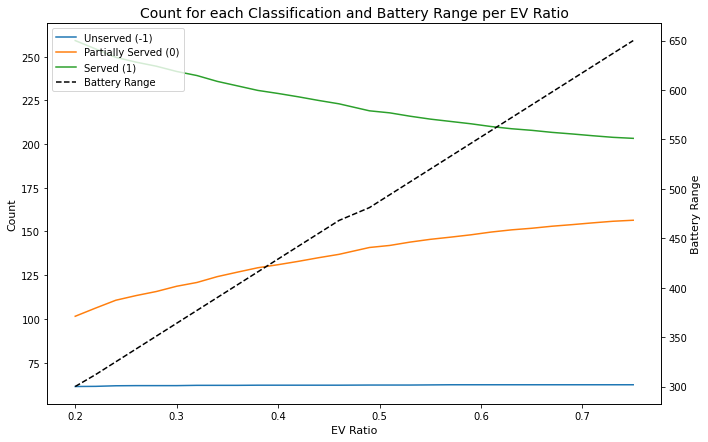

In [49]:
fig, ax1 = plt.subplots(figsize=(11, 7))

# Define a dictionary to map classes to labels
class_labels = {'-1': 'Unserved (-1)', '0': 'Partially Served (0)', '1': 'Served (1)'}

# Plot the lines for classification counts on the first y-axis
for classif in ['-1', '0', '1']:
    subset = classification_counts_mean.copy()
    ax1.plot(subset['ev_ratio'], subset[classif], label=class_labels[classif])

# Create a second y-axis
ax2 = ax1.twinx()

# Plot the line for Battery Range on the second y-axis
ax2.plot(growth_df['EV_Ratio'], growth_df['Battery_Range'], label='Battery Range', linestyle='--', color="black")

# Add labels and title
ax1.set_xlabel('EV Ratio', fontsize= 11)
ax1.set_ylabel('Count', fontsize= 11)
ax2.set_ylabel('Battery Range', fontsize= 11)
ax1.grid(False)
plt.title('Count for each Classification and Battery Range per EV Ratio', fontsize= 14)

# Add legend
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=0)

plt.show()


### Using Years on the X-axis and using the dataframe to show the graphs corresponding EV ratio and range

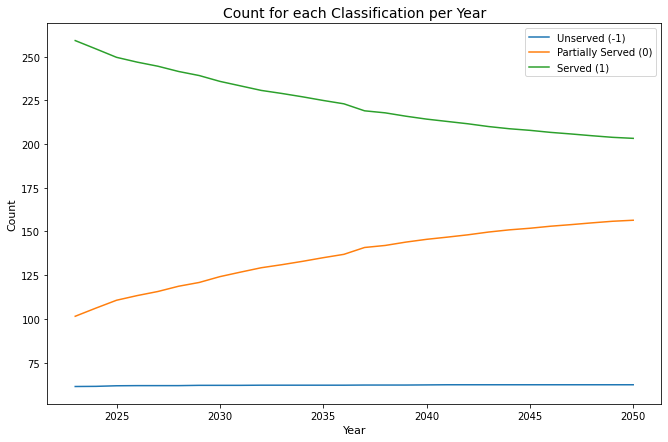

,Year,ev_ratio,Battery_Range
0,2023,0.20000,300
1,2024,0.22000,312
2,2025,0.24000,325
3,2026,0.26000,338
4,2027,0.28000,351
5,2028,0.30000,364
6,2029,0.32000,377
7,2030,0.34000,390
8,2031,0.36000,403
9,2032,0.38000,416


In [54]:
# Rename the 'EV_Ratio' column in growth_df to 'ev_ratio' to match classification_counts_mean
growth_df = growth_df.rename(columns={'EV_Ratio': 'ev_ratio'})

# Merge the classification_counts_mean DataFrame with the growth_df DataFrame on 'ev_ratio'
merged_df = pd.merge(classification_counts_mean.reset_index(), growth_df, on='ev_ratio')

fig, ax1 = plt.subplots(figsize=(11, 7))

# Define a dictionary to map classes to labels
class_labels = {'-1': 'Unserved (-1)', '0': 'Partially Served (0)', '1': 'Served (1)'}

# Plot the lines for classification counts on the first y-axis
for classif in ['-1', '0', '1']:
    subset = merged_df.copy()
    ax1.plot(subset['Year'], subset[classif], label=class_labels[classif])

# Add labels and title
ax1.set_xlabel('Year', fontsize= 11)
ax1.set_ylabel('Count', fontsize= 11)
ax1.grid(False)
plt.title('Count for each Classification per Year', fontsize= 14)

# Add legend
lines, labels = ax1.get_legend_handles_labels()
ax1.legend(lines, labels, loc=0)

plt.show()

# Show the dataframe
merged_df[['Year', 'ev_ratio', 'Battery_Range']]
